In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
import numpy as np
import math

Jansen-Rit Neural Mass Model in PyRates
=====================

**1. Model Description**
    - Circuit structure
    - pulse-to-wave transform
    - wave-to-pulse transform

**2. PyRates Implementation**
    - Axon
    - Synapses
    - Population
    - Circuit

**3. Model Validation**
    - Replicating Jansen & Rit (1995), single circuit dynamics experiment

1. Model Description
--------------------

**Circuit Structure**

<img src="img/JR_circuit_original.png",width=400,height=400>

    - 3 populations (pyramidal cells, excitatory interneurons, inhibitory interneurons)
    - population dynamics described by average membrane potential and average firing rate
    - Pulse-to-wave / wave-to-pulse transforms transfer average firing rates into average
      membrane potentials and vice versa
    - Populations communicate with each other via average firing rate projections

**Pulse-To-Wave Transform**

The pulse-to-wave transform is responsible for transforming average firing rates arriving at
the synapses of a population (i.e. neural mass) into an average membrane potential of that population.
The average membrane potential resulting from a single synapse is given the convolution of the incoming firing rates with an impulse response function:
<br/>

$$v(t) = \int_{t' = -\infty}^{t} h_{e/i}(t - t') \otimes p(t') dt'$$

$v = $  average post-synaptic membrane potential <br/>
$h_{e/i} = $ excitatory or inhibitory synaptic kernel (see below) <br/>
$p = $ incoming pre-synaptic average firing-rate <br/>

*Impulse Response Function:*

$$h_{e/i}(t) = \frac{H_{e/i} t \exp(\frac{-t}{\tau_{e/i}})}{\tau_{e/i}}$$

$H_{e/i} = $ efficacy of excitatory/inhibitory synapse (negative for inhibitory ones) <br/>
$\tau_{e/i} = $ lumped time constant of excitatory/inhibitory synapse

**Wave-To-Pulse Transform**

The wave-to-pulse transform is responsible for transforming the average membrane potential of a 
population into an average firing rate this population is generating at its axon hillok. 
This average firing rate is then projected to the synapses of other populations 
and is given by a sigmoidal transform:

$$p(t) = \frac{2e_0}{1 + \exp(r(v_0 - v(t)))}$$

$e_0 = $ half of the maximum firing rate <br/>
$r = $ steepness of the sigmoid <br/>
$v_0 = $ membrane potential threshold. If $v = v_0$, $p(t) = 0.5$ 


2. PyRates Implementation
-------------------------

**Axon**

Implements the Wave-To-Pulse transform described above.
    

Default maximum firing rate (2*e0):  5.0  Hz.
Default membrane potential threshold (v0):  0.006  V.
Default sigmoid steepness (r):  560.0  Hz.


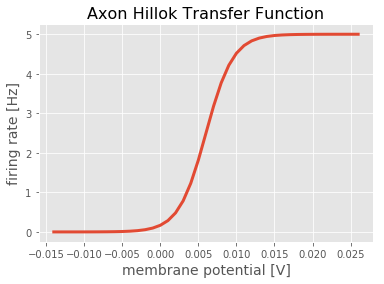

In [2]:
from core.axon import JansenRitAxon

# initialize axon
axon = JansenRitAxon()

# print default parameters (can be changed during initialization)
print('Default maximum firing rate (2*e0): ', axon.transfer_function_args['max_firing_rate'], ' Hz.')
print('Default membrane potential threshold (v0): ', axon.transfer_function_args['membrane_potential_threshold'], ' V.')
print('Default sigmoid steepness (r): ', axon.transfer_function_args['sigmoid_steepness'], ' Hz.')

# plot axon
fig, axes = plt.subplots()
axes = axon.plot_transfer_function(create_plot=False, axes=axes)

**Synapses**

Implement the pulse-to-wave transform described above.

Default synaptic efficacies (He/Hi):  [0.0032500000000000003, -0.022]  V.
Default synaptic time constants (tau_e/tau_i):  [0.01, 0.02]  s.


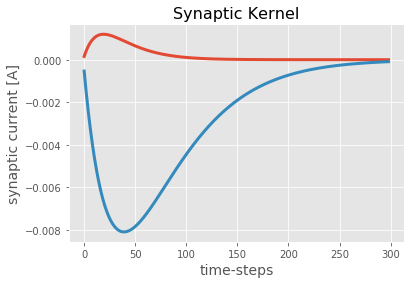

In [3]:
from core.synapse import JansenRitExcitatorySynapse, JansenRitInhibitorySynapse

# instantiate an excitatory and an inhibitory synapse
synapse_e = JansenRitExcitatorySynapse(bin_size=5e-4, max_delay=0.15)
synapse_i = JansenRitInhibitorySynapse(bin_size=5e-4, max_delay=0.15)

# print default parameters (can be changed during initialization)
print('Default synaptic efficacies (He/Hi): ', [synapse_e.efficacy, synapse_i.efficacy], ' V.')
print('Default synaptic time constants (tau_e/tau_i): ', [synapse_e.kernel_function_args['tau'], synapse_i.kernel_function_args['tau']], ' s.')

# plot synaptic kernels
fig, axes = plt.subplots()
axes = synapse_e.plot_synaptic_kernel(create_plot=False, axes=axes)
axes = synapse_i.plot_synaptic_kernel(create_plot=False, axes=axes)

**Populations**
    
    - 3 types: Pyramidal cells, excitatory interneurons, inhibitory interneurons
    - Consist of a Jansen-Rit axon and an excitatory Jansen-Rit synapse
    - Pyramidal cells have an additional inhibitory Jansen-Rit synapse

Text(0.5,1,'IINs')

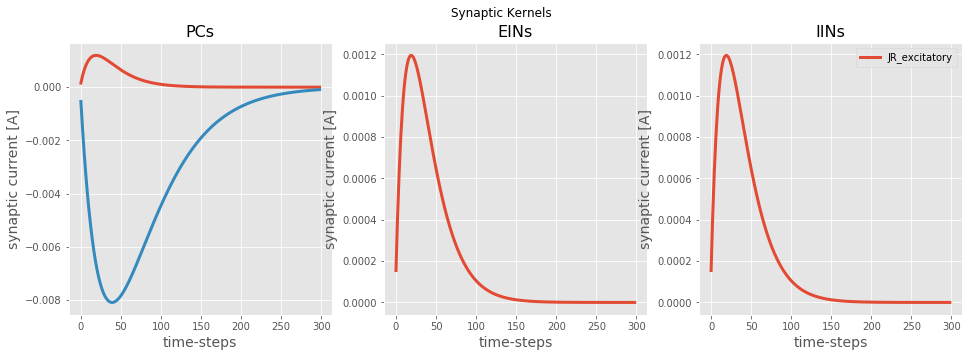

In [4]:
from core.population import JansenRitPyramidalCells, JansenRitInterneurons

# instantiate all 3 populations
pcs = JansenRitPyramidalCells(step_size=5e-4, max_synaptic_delay=0.15)
eins = JansenRitInterneurons(step_size=5e-4, max_synaptic_delay=0.15)
iins = JansenRitInterneurons(step_size=5e-4, max_synaptic_delay=0.15)

# plot synaptic kernels of each population
fig, axes = plt.subplots(1,3, figsize=(16,5))
plt.suptitle('Synaptic Kernels')
ax1 = axes[0]
ax1 = pcs.plot_synaptic_kernels(create_plot=False, axes=ax1)
ax1.set_title('PCs')
ax2 = axes[1]
ax2 = eins.plot_synaptic_kernels(create_plot=False, axes=ax2)
ax2.set_title('EINs')
ax3 = axes[2]
ax3 = iins.plot_synaptic_kernels(create_plot=False, axes=ax3)
ax3.set_title('IINs')

**Circuit**

 Models cortical column as interaction between PCs, EINs and IINs.

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


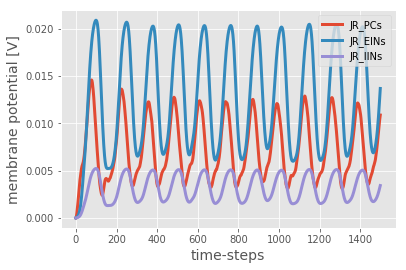

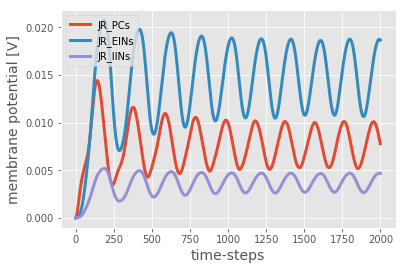

In [5]:
from core.circuit import JansenRitCircuit

# instantiate circuit
jrc = JansenRitCircuit(step_size=5e-4, max_synaptic_delay=0.15)

# define input to circuit
synaptic_input = np.zeros((2000, 3, 2))                      # 2000 time-steps (1 s) x 3 populations x 2 synapses
synaptic_input[:, 0, 0] = 22 * np.random.randn(2000) + 220   # gaussian input to PCs
simulation_time = 1.                                         # 1 s simulation duration

# simulate circuit behavior
jrc.run(simulation_time=simulation_time, synaptic_inputs=synaptic_input)

# plot resulting membrane potential traces
fig, axes = plt.subplots()
axes = jrc.plot_population_states(create_plot=False, axes=axes)

3. Model Validation
-------------------

**Replicating Jansen & Rit (1995)**

*Single circuit experiment:*

    - Circuit with parametrization as reported above, consisting of PCs, EINs and IINs
    - Simulation of circuit behavior for 2 s. 
    - Uniformly distributed input between 120 and 320 Hz delivered to PCs throughout the simulation
    - 6 conditions for lumped connectivity constant C: 68, 128, 135, 270, 675, 1350
    - Results can be seen in figure below
    
<img src="img/JR_single_circuit_dynamics.jpg",width=400,height=400>

*Replication of the single circuit experiment with PyRates:*

In [14]:
from core.population import JansenRitPyramidalCells, JansenRitInterneurons
from core.circuit import Circuit

# circuit parameters
step_size = 1e-3
max_synaptic_delay = 0.2
n_populations = 3
n_synapses = 2

# instantiate cell populations and connectivity parameters
pcs = JansenRitPyramidalCells(step_size=step_size, max_synaptic_delay=max_synaptic_delay)
eins = JansenRitInterneurons(step_size=step_size, max_synaptic_delay=max_synaptic_delay)
iins = JansenRitInterneurons(step_size=step_size, max_synaptic_delay=max_synaptic_delay)

connectivity = np.zeros((n_populations, n_populations, n_synapses))
delays = np.zeros((n_populations, n_populations))

# define experimental conditions
C = [68., 128., 135., 270., 675., 1350.]
simulation_time = 2.5                                                 # 0.5 additional cut-off seconds 
time_steps = int(simulation_time / step_size)
synaptic_input = np.zeros((time_steps, n_populations, n_synapses))                        
synaptic_input[:, 0, 0] = np.random.uniform(120, 320, time_steps)    # input to PCs

# perform experiment for each condition

pc_state_coll = list()                                               # used to collect the membrane potential of the PCs

for c in C:
    
    # build connectivity matrix
    connectivity[:, :, 0] = np.array([[0., 0.8 * c, 0.],
                                      [1.0 * c, 0., 0.],
                                      [0.25 * c, 0., 0.]])
    connectivity[:, :, 1] = np.array([[0., 0., 0.25 * c],
                                      [0., 0., 0.],
                                      [0., 0., 0.]])
    
    # instantiate circuit
    jrc = Circuit(populations=[pcs, eins, iins], connectivity=connectivity, delays=delays, step_size=step_size)
    
    # perform experiment
    jrc.run(synaptic_inputs=synaptic_input, simulation_time=simulation_time)
    
    # collect PC membrane potentials
    pc_state_coll.append(np.squeeze(jrc.get_population_states(0, [0], time_window=[0.5, 2.5])))

    # clear state history of populations
    pcs.clear()
    eins.clear()
    iins.clear()

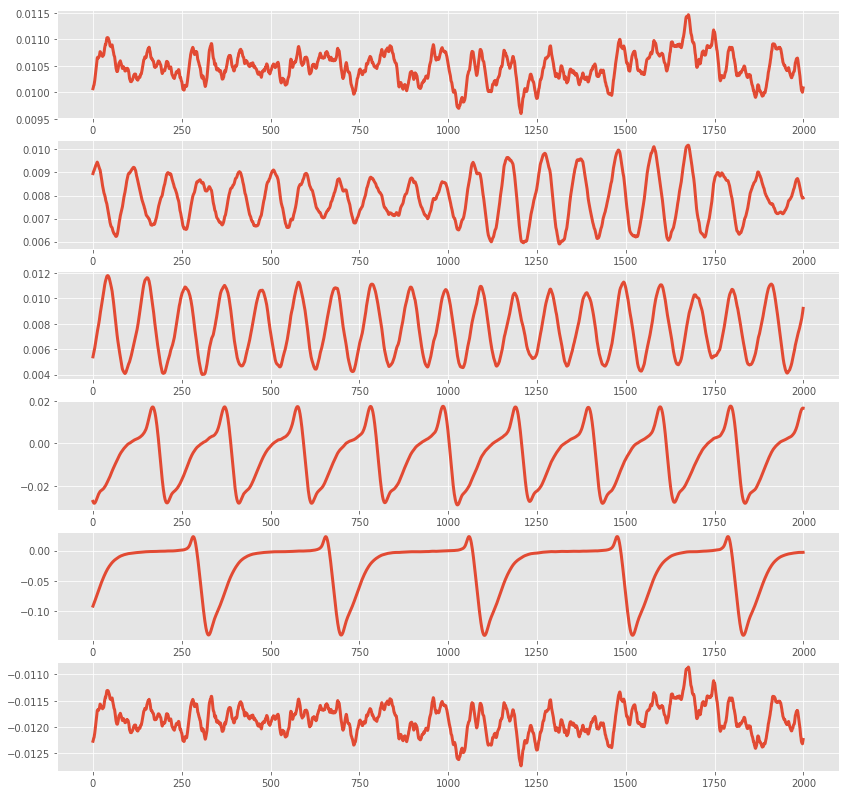

In [15]:
# plot results
fig, axes = plt.subplots(6, 1, figsize=(14, 14))

for i in range(len(pc_state_coll)):
    axes[i].plot(pc_state_coll[i])

**Replication with leaky-capacitor populations**

    - See documentation of leaky-capacitor population for an explanation of the mathematical formalism
    - Same circuit set-up, just different description of the population dynamics (still a mean-field 
      approximation of the leaky integrate-and-fire neuron)

In [16]:
from core.population import Population

# instantiate populations
pcs = Population(synapses=['AMPACurrentSynapse', 'GABAACurrentSynapse'],
                 axon='KnoescheAxon',
                 step_size=step_size,
                 max_synaptic_delay=max_synaptic_delay)
eins = Population(synapses=['AMPACurrentSynapse'],
                  axon='KnoescheAxon',
                  step_size=step_size,
                  max_synaptic_delay=max_synaptic_delay)
iins = Population(synapses=['AMPACurrentSynapse'],
                  axon='KnoescheAxon',
                  step_size=step_size,
                  max_synaptic_delay=max_synaptic_delay)

# perform experiment for each condition

pc_state_coll = list()                                               # used to collect the membrane potential of the PCs

for c in C:
    
    # build connectivity matrix
    connectivity[:, :, 0] = np.array([[0., 0.8 * c, 0.],
                                      [1.0 * c, 0., 0.],
                                      [0.25 * c, 0., 0.]])
    connectivity[:, :, 1] = np.array([[0., 0., 0.25 * c],
                                      [0., 0., 0.],
                                      [0., 0., 0.]])
    
    # instantiate circuit
    jrc = Circuit(populations=[pcs, eins, iins], connectivity=connectivity, delays=delays, step_size=step_size)
    
    # perform experiment
    jrc.run(synaptic_inputs=synaptic_input, simulation_time=simulation_time)
    
    # collect PC membrane potentials
    pc_state_coll.append(np.squeeze(jrc.get_population_states(0, [0], time_window=[0.5, 2.5])))

    # clear state history of populations
    pcs.clear()
    eins.clear()
    iins.clear()

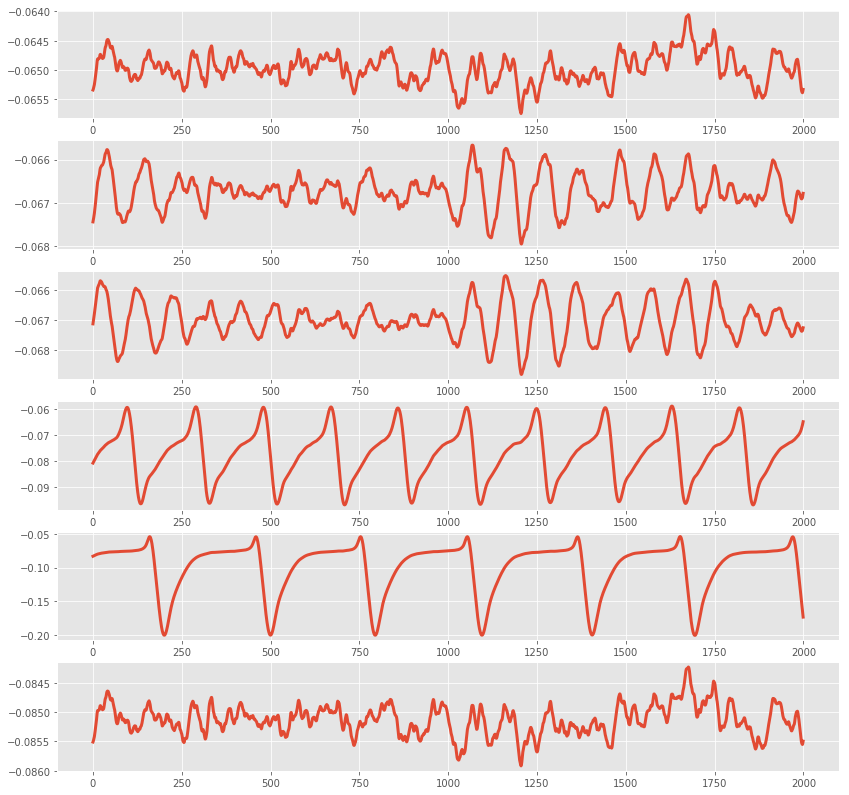

In [17]:
# plot results
fig, axes = plt.subplots(6, 1, figsize=(14, 14))

for i in range(len(pc_state_coll)):
    axes[i].plot(pc_state_coll[i])